<a href="https://colab.research.google.com/github/4may/MIResearch/blob/master/matminer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matminer

2018年に、Matmierの[解説論文](https://perssongroup.lbl.gov/papers/ward-2018-matminer.pdf)が出ている。

この論文の内容を整理してみる。

## Matminerの特徴

### データ抽出

**特徴１：色んなDBからデータを取得できる**

基本的に、各DBごとに用意されているAPIのラッパーとしてMatmierが働く。

* Citrination
* The Materials Project (MP) ※pymatgenのラッパー
* The Materials Data Facility (MDF) ※MDF製ライブラリのラッパー
* The Materials Platform for Data Science (MPDS)
* 任意のmongo DB

なお、取得したデータは、pandasのDataFrame型となる。
メリットは以下の通り。

* いちいち個々のライブラリを参照しなくて済むので、管理が楽。ソースも綺麗になる。(各DBのAPI keyは必要)
* 取得データがDataFrame型なので、データの統合が楽ちん。

**特徴２：ビルトインのデータセットがある。**

* 第一原理計算で作成されている。
* プログラム的には一行で書ける。
* DBアクセスなし

具体的には以下のデータセットが用意されている。

* 1181 DFT-based elastic tensors
* 941 DFT-based piezoelectric tensors
* 1056 DFT-based dielectric constants 
* 3938 DFT-based formation energies

アルゴリズムの動作確認も楽ちんだね！

**特徴３：ファイルからデータをロードできる**

* 対応フォーマットは、CSV, Excelなどいろいろ
* Matminerというよりpandasのメリットだが、、、

#### データの特徴量化(featurization)

Matminerでは、材料に関する特性をdescriptors(feature)に変換することができる。これによって、人間が目で見てわかるようなデータから、機械学習に与えられる形式のデータを得ることができる。

材料の重要な特性としては、例えば以下がある。

* 組成要素の電気陰性度の差分
* 原子半径の総和

Matminerでは5つのモジュールに総計47個のFeaturizerが用意されている。要は47種類のdescriptorの作り方があるということ。例えば、ElementProperty Featurizerは、イオン半径や融点の標準偏差など、様々な記述子を作り出すことができる。

また、5つのモジュールの他に、FunctionFeaturizerと呼ばれるFeaturizerもある。いくつかの特徴量を入力として、logを取ったり掛け算したりなどの数値演算を行うことができる。これによって、大きな特徴量を小さな特徴量に変換することができる。


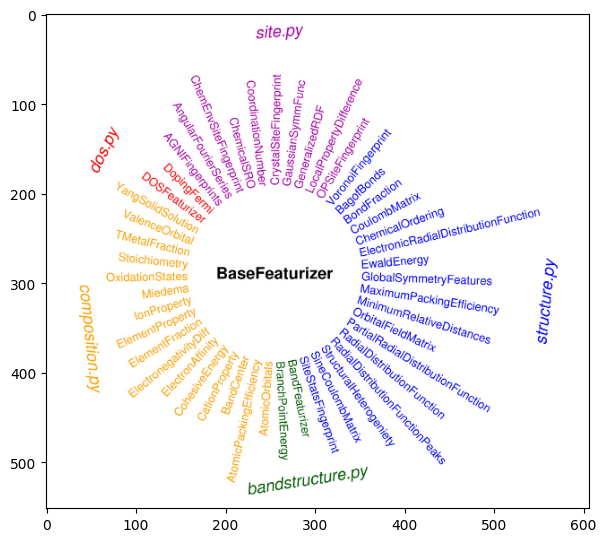

In [0]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7), dpi=100)
image = plt.imread("featurizer.png")
plt.imshow(image)

MatminerのFeaturizerを使うメリットは以下の通り。

* 分散しているFeaturizationの手法を統合的に使うことができる。いちいち個別の手法をインポートしなくて済む。
* Featurizerの出力オブジェクトをそのままscikit-learnのアルゴリズムに渡すことができる。

#### データの可視化

Matminerでは、データを可視化するためのクラスFigRecipesを用意している。FigRecipesは、Plotlyという別のpythonライブラリのラッパーである。ちなみに、Plotlyには、PlotlyFigクラスというグラフ描画のためのクラスがある。

Plotlyを選んでいる理由は三つある。

* 外れ値を見分けやすい。MIでは、外れ値が重要な意味を持っていることが多々ある。
* JSONフォーマットで画像を作成している。
* 作成した画像をweb上で共有できる。(ローカルだけで作成することもできる)

Matminerでは、7種類のグラフを用意している。

* x-yプロット(二次元の図)
* 散布図
* ヒストグラム
* 棒グラフ
* ヒートマップ
* パラレルプロット
* バイオリンプロット

Matminerで作成する全ての図は、PlotlyDictクラスとして扱うことができる。

## Matminerを使ってみよう！

### Matminerを使うための環境を整えよう

google colabにはインストールされていないため、モジュールをpipで落としてくる必要がある。

In [0]:
pip install matminer

     |████████████████████████████████| 6.8MB 7.0MB/s 
     |████████████████████████████████| 2.7MB 45.4MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 194kB 54.6MB/s 
     |████████████████████████████████| 11.5MB 38.5MB/s 
     |████████████████████████████████| 829kB 45.0MB/s 
     |████████████████████████████████| 5.6MB 42.9MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 112kB 54.4MB/s 
     |████████████████████████████████| 296kB 52.3MB/s 
     |████████████████████████████████| 552kB 53.1MB/s 
  Created wheel for matminer: filename=matminer-0.6.3-cp36-none-any.whl size=1167162 sha256=d557b8981bcf062bdc3d8ca35d17754866b630a85b12362ab1648d8147bc20fe
  Stored in directory: /root/.cache/pip/wheels/ba/16/21/291dd912fe201fdbb38d09af570cdab5d8e0dab98162b6ea70
  Created wheel for pymatgen: filename=pymatgen-2020.4.29-cp36-cp36m-l

plotlyなど、依存モジュールもインストールすることができた。

### データを抽出して、可視化してみよう

まずは、Materials Projectからデータをロードしよう。ここでは、要素が１つの材料のdensityを取得しよう。

In [0]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

mpdr = MPDataRetrieval(api_key='MY_API_KEY')
df_mp = mpdr.get_dataframe(criteria={"nelements":1}, properties=["density", "volume", "pretty_formula"])


100%|██████████| 708/708 [00:01<00:00, 427.45it/s]

データを表示してみよう。

In [0]:
df_mp.head()

,density,volume,pretty_formula
material_id,,,
mp-1056699,20.870081,75.755585,U
mp-1244924,4.509260,1762.706722,Ti
mp-632291,0.142153,23.548143,H2
mp-684673,3.358903,15.851954,S
mp-1096826,6.407091,38.835171,As


描画してみよう。

In [0]:
from matminer.figrecipes.plot import PlotlyFig

#図で使うデータと、軸のタイトルを指定
pf = PlotlyFig(df_mp, x_title='pretty_formula', y_title='volume')
#プロット方法とプロット対象のデータを指定
pf.xy(xy_pairs=[('pretty_formula', 'volume')])

むむ、、、google colab上では表示されない。

とりあえず、plotlyで表示してみるか。plotlyでDataFrameオブジェクトを描画するときは、cufflinksというライブラリが便利みたい。

In [0]:
pip install cufflinks

In [0]:
import cufflinks as cf

cf.go_offline()
df_mp.iplot(kind='scatter', x='volume', y=['density'])

こっちも上手く表示されない。。。

DataFrameオブジェクトのplot関数でええか。

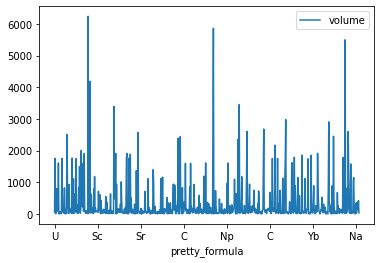

In [0]:
df_mp.plot(x='pretty_formula', y='volume')